In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = (x_train.astype(np.float32) / 255.0) * 2.0 - 1.0
x_test = (x_test.astype(np.float32) / 255.0) * 2.0 - 1.0
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf

def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=2.0))  # max_val=2.0 because [-1,1]


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dense, Flatten, Reshape, BatchNormalization, Dropout
from tensorflow.keras.models import Model

input_img = Input(shape=(32, 32, 3))

# Encoder
x = Conv2D(32, 3, activation='relu', padding='same')(input_img)
x = MaxPooling2D(2, padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(2, padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(2, padding='same')(x)
x = Flatten()(x)

encoded = Dense(512, activation='relu')(x)
encoded = Dropout(0.3)(encoded)

# Classifier Head
classifier_output = Dense(10, activation='softmax', name='class_output')(encoded)

# Decoder
x = Dense(4 * 4 * 128, activation='relu')(encoded)
x = Reshape((4, 4, 128))(x)

x = Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)


In [ ]:

# Final layer uses tanh
decoded = Conv2D(3, 3, activation='tanh', padding='same', name='recon_output')(x)

# Full model
autoencoder = Model(inputs=input_img, outputs=[decoded, classifier_output])
autoencoder.compile(
    optimizer='adam',
    loss={'recon_output': ssim_loss, 'class_output': 'categorical_crossentropy'},
    loss_weights={'recon_output': 0.4, 'class_output': 0.6},
    metrics={'recon_output': 'mse', 'class_output': 'accuracy'}
)

autoencoder.summary()



In [33]:
# Then train with both outputs
autoencoder.fit(
    x_train,
    {'recon_output': x_train, 'class_output': y_train_cat},
    validation_data=(x_test, {'recon_output': x_test, 'class_output': y_test_cat}),
    epochs=30,
    batch_size=256,
    shuffle=True
)


Epoch 1/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 69s 278ms/step - class_output_accuracy: 0.3715 - class_output_loss: 1.9162 - loss: 1.1694 - recon_output_loss: 0.0492 - recon_output_mse: 0.0492 - val_class_output_accuracy: 0.1600 - val_class_output_loss: 4.0041 - val_loss: 2.4191 - val_recon_output_loss: 0.0615 - val_recon_output_mse: 0.0615
Epoch 2/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 54s 276ms/step - class_output_accuracy: 0.6171 - class_output_loss: 1.0790 - loss: 0.6633 - recon_output_loss: 0.0398 - recon_output_mse: 0.0398 - val_class_output_accuracy: 0.1673 - val_class_output_loss: 4.8682 - val_loss: 2.9364 - val_recon_output_loss: 0.0603 - val_recon_output_mse: 0.0602
Epoch 3/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 56s 287ms/step - class_output_accuracy: 0.6850 - class_output_loss: 0.8914 - loss: 0.5509 - recon_output_loss: 0.0400 - recon_output_mse: 0.0400 - val_class_output_accuracy: 0.5072 - val_class_output_loss: 1.5182 - val_loss: 0.9240 - val_recon_output_loss: 0.0376 - val_recon_output_mse: 0.

In [34]:
# Define encoder model for feature extraction
encoder = Model(inputs=input_img, outputs=encoded)
encoded_imgs = encoder.predict(x_train)

# Flatten encoded features
flattened = encoded_imgs.reshape(len(encoded_imgs), -1)

# Apply KMeans to flattened features
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(flattened)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [35]:
from sklearn.metrics import silhouette_score

# Evaluate clustering performance
sil_score = silhouette_score(encoded_imgs, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.0851


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


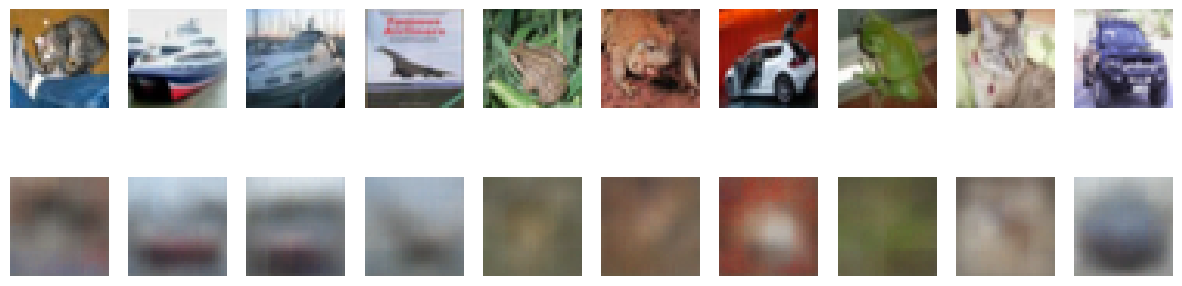

In [ ]:
recons = autoencoder.predict(x_test[:10])[0]
recons = (recons + 1.0) / 2.0  # back to [0, 1]

# Plot
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    axes[0, i].imshow((x_test[i] + 1.0) / 2.0)  # Original unscaled
    axes[1, i].imshow(recons[i])               # Reconstructed
    axes[0, i].axis("off")
    axes[1, i].axis("off")
plt.show()



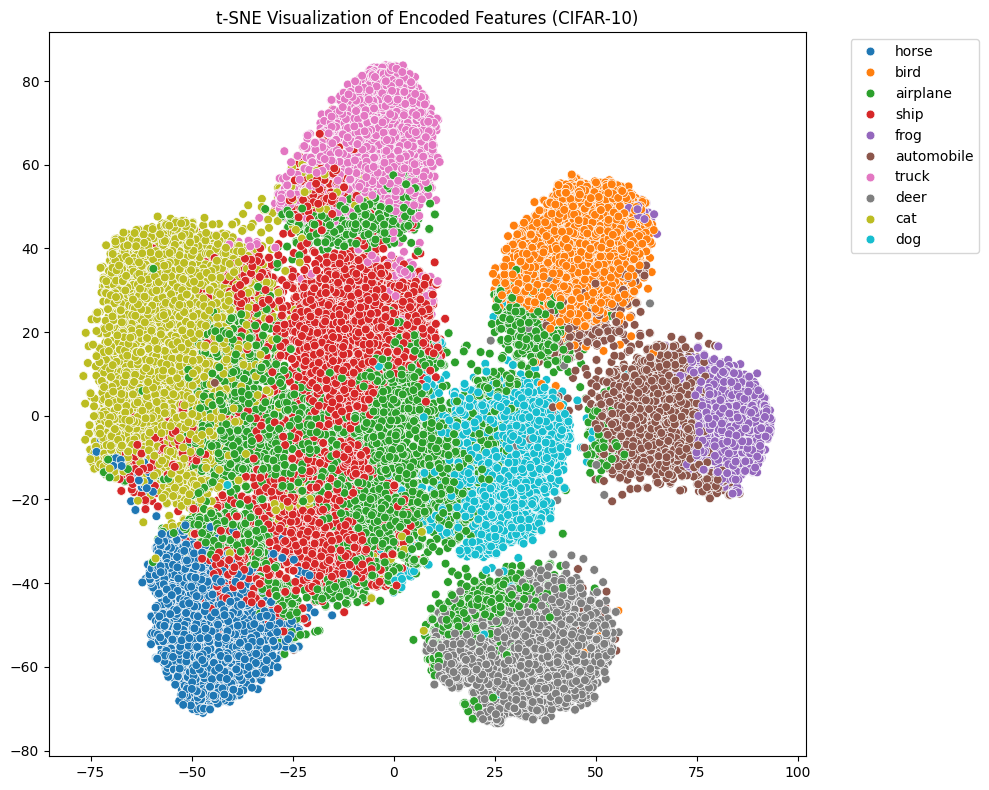

In [37]:
from sklearn.manifold import TSNE
import seaborn as sns

# Reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(flattened)

# CIFAR-10 label names
cifar10_labels = np.array([
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
])

# Convert numeric labels to readable names
named_labels = cifar10_labels[cluster_labels]  # Use cluster_labels from KMeans

# Plot with names
plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=named_labels, palette="tab10", s=40)
plt.title("t-SNE Visualization of Encoded Features (CIFAR-10)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [ ]:
from tensorflow.keras.losses import MeanSquaredError

mse = MeanSquaredError()

decoded_imgs = autoencoder.predict(x_test)[0]
loss = mse(x_test, decoded_imgs).numpy()

print(f"Average MSE on test set: {loss:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


ValueError: Structures don't have the same nested structure.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Reduce before clustering
encoded_pca = PCA(n_components=50).fit_transform(encoded_imgs)
kmeans = KMeans(n_clusters=10)
labels = kmeans.fit_predict(encoded_pca)
score = silhouette_score(encoded_pca, labels)
print(f"PCA-based silhouette score: {score:.4f}")

NameError: name 'encoded_features' is not defined